In [821]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set()

In [829]:
# Import migration database from the World Bank
migration_WB = pd.read_csv('inmigration.csv',header=0,names = ['origin_name', 'origin_code',
       'gender', 'gender_code',
       'dest_name', 'dest_code', '1960', '1970',
       '1980', '1990', '2000'])

In [832]:
migration_WB.head(5)

,origin_name,origin_code,gender,gender_code,dest_name,dest_code,1960,1970,1980,1990,2000
0,Afghanistan,AFG,Female,FEM,Afghanistan,AFG,0,0,0,0,0
1,Afghanistan,AFG,Female,FEM,Albania,ALB,0,0,0,0,0
2,Afghanistan,AFG,Female,FEM,Algeria,DZA,22,8,6,5,4
3,Afghanistan,AFG,Female,FEM,American Samoa,ASM,0,0,0,0,0
4,Afghanistan,AFG,Female,FEM,Andorra,AND,0,0,0,2,3


In [838]:
migration_WB.isnull().sum()

origin_name    3
origin_code    5
gender         5
gender_code    5
dest_name      5
dest_code      5
1960           5
1970           5
1980           5
1990           5
2000           5
dtype: int64

In [837]:
migration_WB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160781 entries, 0 to 160780
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   origin_name  160778 non-null  object
 1   origin_code  160776 non-null  object
 2   gender       160776 non-null  object
 3   gender_code  160776 non-null  object
 4   dest_name    160776 non-null  object
 5   dest_code    160776 non-null  object
 6   1960         160776 non-null  object
 7   1970         160776 non-null  object
 8   1980         160776 non-null  object
 9   1990         160776 non-null  object
 10  2000         160776 non-null  object
dtypes: object(11)
memory usage: 13.5+ MB


In [839]:
# NaN values to 0, strings to integers
def cleaning_values(x):   
    try:
        np.int(x)
        x = np.int(x)
    except ValueError:
        x = 0    #lambda x: True if x % 2 == 0 else False
    return x

for year in ['1960', '1970','1980', '1990', '2000']:
    migration_WB[year] = migration_WB[year].apply(lambda x: cleaning_values(x))

In [840]:
# correct some country names
migration_WB.replace(['Russian Federation','Hong Kong SAR, China',"Cote d'Ivoire",'Korea, Dem. Rep.','Venezuela, RB'],
                     ['Russia','Hong Kong',"Côte d'Ivoire",'South Korea','Venezuela'],inplace=True)

In [842]:
# add geographic coordinates to the origin and destination countries 
countries_loc = pd.read_csv('countries_lon_lat.csv')[['Unnamed: 1','Unnamed: 2','Unnamed: 3','Unnamed: 4']]
countries_loc.columns = ['code', 'lat', 'lon', 'name']
countries_loc.head()

,code,lat,lon,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [844]:
# merge both dataframes on the origin_name and dest_name
migration_ = migration_WB.merge(countries_loc[['lat','lon','name']],how='left',left_on='origin_name',right_on='name').drop('name',axis=1).rename({'lat': 'lat_origin', 'lon': 'lon_origin'}, axis=1)
migration = migration_.merge(countries_loc[['lat','lon','name']],how='left',left_on='dest_name',right_on='name').drop('name',axis=1).rename({'lat': 'lat_dest', 'lon': 'lon_dest'}, axis=1)
migration.head(5)

,origin_name,origin_code,gender,gender_code,dest_name,dest_code,1960,1970,1980,1990,2000,lat_origin,lon_origin,lat_dest,lon_dest
0,Afghanistan,AFG,Female,FEM,Afghanistan,AFG,0,0,0,0,0,33.93911,67.709953,33.939110,67.709953
1,Afghanistan,AFG,Female,FEM,Albania,ALB,0,0,0,0,0,33.93911,67.709953,41.153332,20.168331
2,Afghanistan,AFG,Female,FEM,Algeria,DZA,22,8,6,5,4,33.93911,67.709953,28.033886,1.659626
3,Afghanistan,AFG,Female,FEM,American Samoa,ASM,0,0,0,0,0,33.93911,67.709953,-14.270972,-170.132217
4,Afghanistan,AFG,Female,FEM,Andorra,AND,0,0,0,2,3,33.93911,67.709953,42.546245,1.601554


# Which countries receive more inmigrants and which ones emigrate more?

In [847]:
# focussed on the 2000s. We dont compare the genres here.

# top 15 countries with more emigrants during the 2000s
top_emigrants = migration.loc[migration['gender_code'].isin(['TOT'])].groupby('origin_name').sum().sort_values('2000',ascending=False)['2000'].head(15)

# top 15 countries with more inmigrants during the 2000s
top_inmigrants = migration.loc[migration['gender_code'].isin(['TOT'])].groupby('dest_name').sum().sort_values('2000',ascending=False)['2000'].head(15)

# top 20 mayor migration processes during the 2000s
largest_migrations = migration.loc[migration['gender_code'].isin(['TOT'])].sort_values('2000',ascending=False)[['origin_name','dest_name','2000','lat_origin','lon_origin','lat_dest','lon_dest']].head(20)

#add a column with a description of the migration process: FROM ___ TO ___: __ k people
largest_migrations['origin_dest'] = largest_migrations.apply(lambda x: x['origin_name'] + '->'+ x['dest_name'] ,axis=1)
largest_migrations['description'] = largest_migrations.apply(lambda x: 'from ' + x['origin_name'] + ' to '+ x['dest_name'] +  ': ' + str( int(x['2000'] / 1000)) + ' k people',axis=1)
largest_migrations.head(5)

,origin_name,dest_name,2000,lat_origin,lon_origin,lat_dest,lon_dest,origin_dest,description
92156,Mexico,United States,9367910,23.634501,-102.552784,37.090240,-95.712891,Mexico->United States,from Mexico to United States: 9367 k people
11641,Bangladesh,India,3789377,23.684994,90.356331,20.593684,78.962880,Bangladesh->India,from Bangladesh to India: 3789 k people
119180,Russia,Ukraine,3613240,61.524010,105.318756,48.379433,31.165580,Russia->Ukraine,from Russia to Ukraine: 3613 k people
150320,Ukraine,Russia,3559975,48.379433,31.165580,61.524010,105.318756,Ukraine->Russia,from Ukraine to Russia: 3559 k people
71318,Kazakhstan,Russia,2584955,48.019573,66.923684,61.524010,105.318756,Kazakhstan->Russia,from Kazakhstan to Russia: 2584 k people


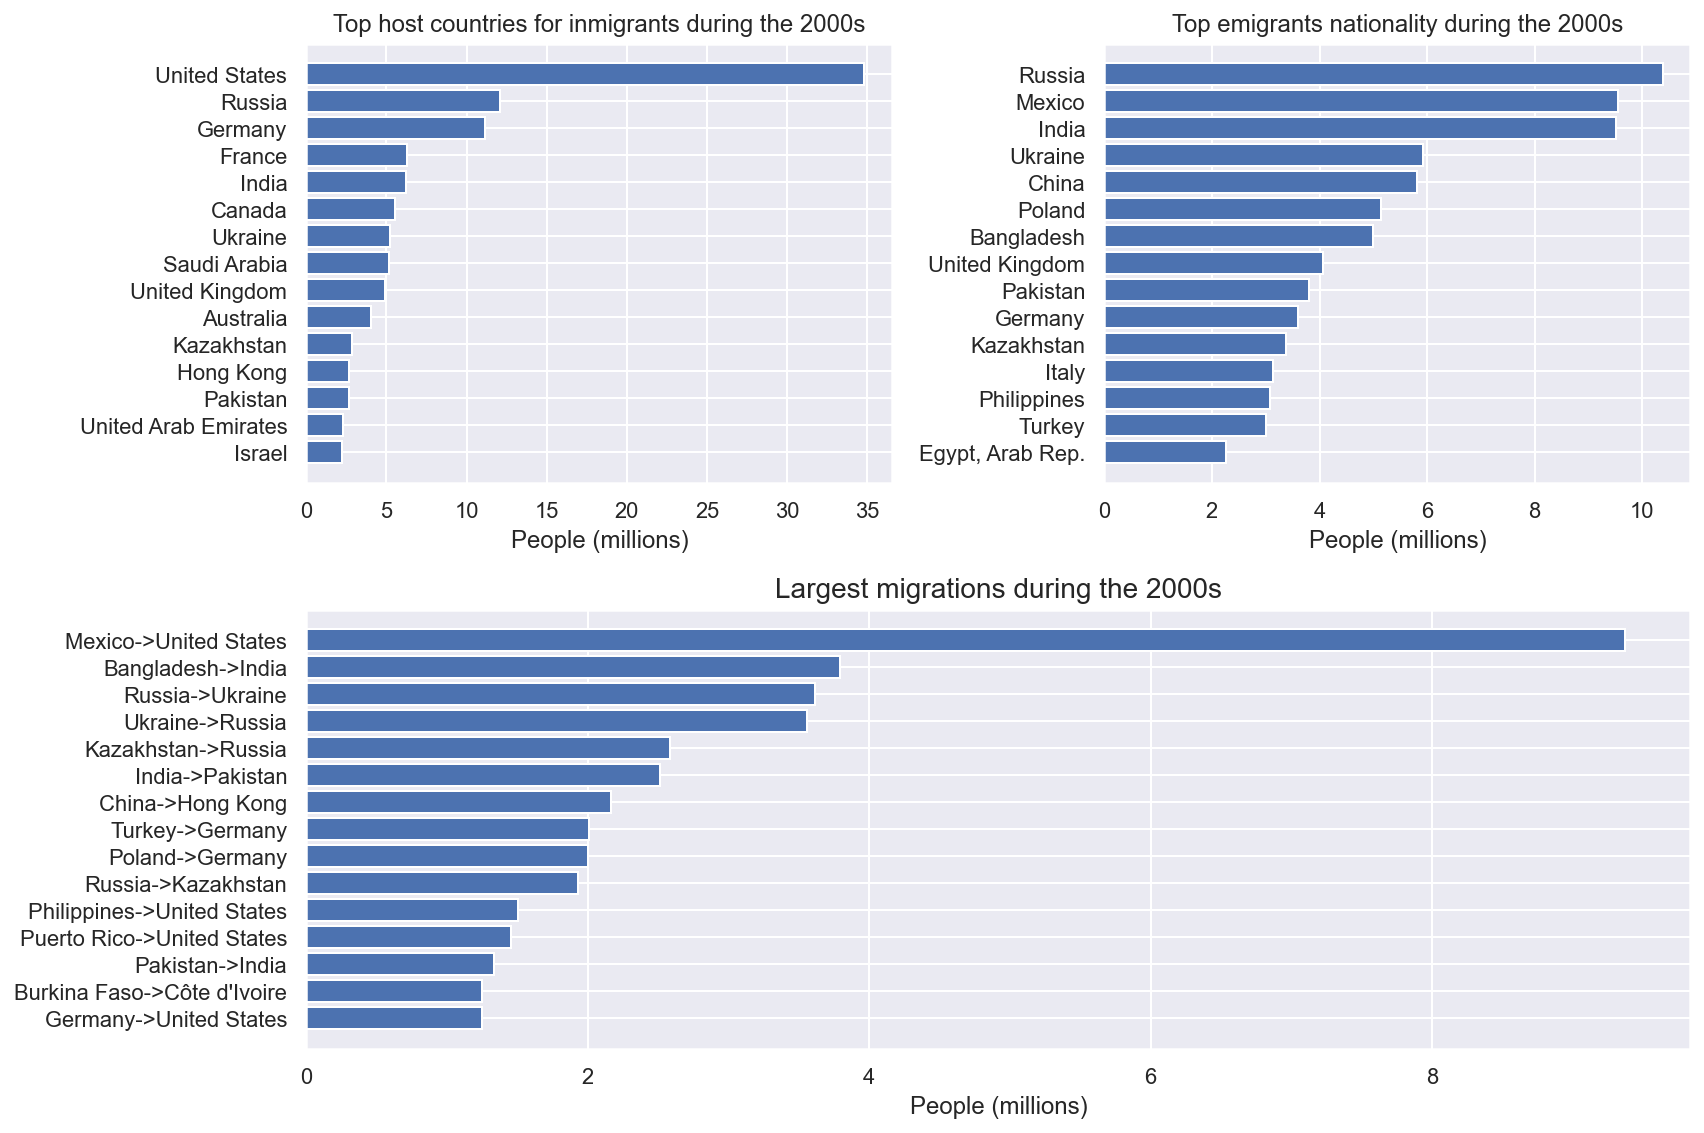

In [848]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
ax1.set_title('Top host countries for inmigrants during the 2000s')
a_1 = ax1.barh(y=np.arange(15,0,-1),width=(top_inmigrants.values / 1000000))
b_1 = ax1.set_yticks(np.arange(15,0,-1))
c_1 = ax1.set_yticklabels(top_inmigrants.index)
d_1 = ax1.set_xlabel('People (millions)')

ax2 = fig.add_subplot(222)
ax2.set_title('Top emigrants nationality during the 2000s')
a_2 = ax2.barh(y=np.arange(15,0,-1),width=top_emigrants.values/  1000000)
b_2 = ax2.set_yticks(np.arange(15,0,-1))
c_2 = ax2.set_yticklabels(top_emigrants.index)
d_2 = ax2.set_xlabel('People (millions)')


ax3 = fig.add_subplot(212)
ax3.barh(y=np.arange(15,0,-1),width=largest_migrations['2000'].values[:15] / 1000000)
aa = ax3.set_yticks(np.arange(15,0,-1))
bb = ax3.set_yticklabels(largest_migrations['origin_dest'][:15].values)
cc = ax3.set_title('Largest migrations during the 2000s',fontsize=14)
dd = ax3.set_xlabel('People (millions)')

fig.tight_layout()

In [721]:
# We now represent the largest migrations on a world-map. 
# The thickness of the lines in proportional to the amount of migrants

import plotly.graph_objects as go

df = largest_migrations       
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    locationmode = 'country names',
    locations = df['origin_name'].append(df['dest_name']),
    hoverinfo = 'skip',
    #text = df['description']  ,#.append(df['dest_name']),
    mode = 'markers',
    marker = dict(
        size = 7,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

for i in range(len(df)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'country names',
            lat = [df['lat_origin'].iloc[i], df['lat_dest'].iloc[i]],
            lon = [df['lon_origin'].iloc[i], df['lon_dest'].iloc[i]],
            hoverinfo = 'text',
            text = df['description'].iloc[i],
            mode = 'lines',
            line = dict(width = ((df['2000'].iloc[i] )/df['2000'].max())*20,color = 'red'),
            opacity = 0.6,
            #hoverinfo = 'skip'
            
        )
    )

fig.update_layout(
    title={
        'text': "Main migration processes during the 2000s",
        'y':0.86,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
    ,    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ),
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'world',
    #    projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
    height=600,
)


fig.update_geos(
    visible=True, resolution=50,
    showcountries=False, countrycolor="RebeccaPurple"
)

fig.show()


# Which are the largest migration processes within South America?

In [850]:
# We slice the previous dataset to the coordinates that enclose South America

lat_south_america = [-56.,10.]
lon_south_america = [-140.,-28.]

largest_migrations_latin_america = migration.loc[migration['gender_code'].isin(['TOT'])].sort_values('2000',ascending=False)[['origin_name','dest_name','2000','lat_origin','lon_origin','lat_dest','lon_dest']]
largest_migrations_latin_america =largest_migrations_latin_america[(largest_migrations_latin_america['lat_origin'].between(lat_south_america[0],lat_south_america[1])) & (largest_migrations_latin_america['lon_origin'].between(lon_south_america[0],lon_south_america[1])) 
                                & (largest_migrations_latin_america['lat_dest'].between(lat_south_america[0],lat_south_america[1])) & (largest_migrations_latin_america['lon_dest'].between(lon_south_america[0],lon_south_america[1]))]
largest_migrations_latin_america['description'] = largest_migrations_latin_america.apply(lambda x: 'from ' + x['origin_name'] + ' to '+ x['dest_name'] +  ' ' + str( int(x['2000'] / 1000)) + ' k people',axis=1)


largest_migrations_latin_america.sort_values('2000',ascending=False,inplace=True)
largest_migrations_latin_america.head(10)

,origin_name,dest_name,2000,lat_origin,lon_origin,lat_dest,lon_dest,description
29790,Colombia,Venezuela,617744,4.570868,-74.297333,6.423750,-66.589730,from Colombia to Venezuela 617 k people
112043,Paraguay,Argentina,331688,-23.442503,-58.443832,-38.416097,-63.616672,from Paraguay to Argentina 331 k people
17102,Bolivia,Argentina,237213,-16.290154,-63.588653,-38.416097,-63.616672,from Bolivia to Argentina 237 k people
28190,Chile,Argentina,219104,-35.675147,-71.542969,-38.416097,-63.616672,from Chile to Argentina 219 k people
152930,Uruguay,Argentina,119169,-32.522779,-55.765835,-38.416097,-63.616672,from Uruguay to Argentina 119 k people
112736,Peru,Argentina,91182,-9.189967,-75.015152,-38.416097,-63.616672,from Peru to Argentina 91 k people
19334,Brazil,Paraguay,82987,-14.235004,-51.925280,-23.442503,-58.443832,from Brazil to Paraguay 82 k people
6167,Argentina,Paraguay,64284,-38.416097,-63.616672,-23.442503,-58.443832,from Argentina to Paraguay 64 k people
29625,Colombia,Ecuador,50510,4.570868,-74.297333,-1.831239,-78.183406,from Colombia to Ecuador 50 k people
6046,Argentina,Chile,45713,-38.416097,-63.616672,-35.675147,-71.542969,from Argentina to Chile 45 k people


In [897]:
import plotly.graph_objects as go

df = largest_migrations_latin_america.head(15)       
fig = go.Figure()


fig.add_trace(go.Scattergeo(
    
    locationmode = 'country names',
    locations = df['origin_name'].append(df['dest_name']),
    hoverinfo = 'skip',
    #text = df['description']  ,#.append(df['dest_name']),
    mode = 'markers',
    name = 'Countries',
    marker = dict(
        size = 7,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
       
    )))

for i in range(len(df)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'country names',
            lat = [df['lat_origin'].iloc[i], df['lat_dest'].iloc[i]],
            lon = [df['lon_origin'].iloc[i], df['lon_dest'].iloc[i]],
            hoverinfo = 'text',
            text = df['description'].iloc[i],
            mode = 'lines',
            line = dict(width = ((df['2000'].iloc[i] )/df['2000'].max())*20,color = 'red'),
            opacity = 0.6,
            name=df['description'].iloc[i],
            
        )
    )

fig.update_layout(
    title={
        'text': "Main migrations in South America during the 2000s",
        'y':0.86,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},    
        template="seaborn",
        font=dict(
        family="Courier New, monospace",
        size=14,
        color="RebeccaPurple"
    ),
    showlegend = True,
    geo = go.layout.Geo(
        scope = 'south america',
        #projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
    height=600,
)


fig.update_geos(
    visible=True, resolution=50,
    showcountries=True, countrycolor="RebeccaPurple"
)


fig.show()
print('Despite the deep economic crisis that Argentina undergoes since the 2000s, it is still an important destination for limiting countries ')


Despite the deep economic crisis that Argentina undergoes since the 2000s, it is still an important destination for limiting countries 


## Argentinian migration: Who moves to Argentina? Where argentines emigrate most?

In [883]:
# countries with less than 'others_threshold' migrants are not considered
others_threshold = 4000

dest_arg = migration[(migration['origin_name']=='Argentina') & (migration['gender']=='Total')][['lat_dest','lon_dest','dest_name','2000']].sort_values('2000',ascending=False)
destination_arg = dest_arg.loc[(dest_arg["2000"] > others_threshold)]

orig_arg = migration[(mig_arg['dest_name']=='Argentina') & (migration['gender']=='Total')][['lat_origin','lon_origin','origin_name','2000']].sort_values('2000',ascending=False)
origin_arg = orig_arg.loc[(orig_arg["2000"] > others_threshold)]

In [895]:
# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    subplot_titles=["Plot 1", "Plot 2", "Plot 3"," "],
    specs=[[{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
           [            None                    , {"type": "bar"}]]
     )


# Add destination locations bar chart
fig.add_trace(
    go.Bar(x=list(destination_arg['dest_name']),y=list(destination_arg['2000'].values.flatten()),marker=dict(color="cyan"), showlegend=False),
    row=1, col=2
)




# Add origin locations bar chart
fig.add_trace(
    go.Bar(x=list(origin_arg['origin_name']),y=list(origin_arg['2000'].values.flatten()),marker=dict(color="crimson"),name='222', showlegend=False),
    row=2, col=2
)

fig.add_trace(go.Scattergeo(
    locationmode = 'country names',
    locations = origin_arg['origin_name'],
    hoverinfo = 'text',
    text = origin_arg['origin_name'].values,
    mode = 'markers',
    marker = dict(
        size =origin_arg['2000']/20000,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.add_trace(go.Scattergeo(
    locationmode = 'country names',
    locations = destination_arg['dest_name'],
    hoverinfo = 'text',
    text = destination_arg['dest_name'].values,
    mode = 'markers',
    marker = dict(
        size =(destination_arg['2000'].values)/20000,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'cyan'
        )
    )))




# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Set theme, margin, and annotation in layout
fig.update_layout(
    title_text="Argentinian migration during the 2000s", height=500,
    template="plotly_dark",
    margin=dict(r=12, t=85, b=10, l=55),
    showlegend=False,
    annotations=[
        dict(
            text="Source: UN",
            showarrow=False,
            font=dict(
                size=12
            ),
            xref="paper",
            yref="paper",
            x=.046,
            y=-0.17)
    ,
        dict(
            text="Emigration",
            showarrow=False,
            #xref="paper",
            #yref="paper",
            x=0.82,
            y=0.99)
        ,
        dict(
            text="Inmigration",
            showarrow=False,
            #xref="paper",
            #yref="paper",
            x=0.82,
            y=0.45)]
    
    
)

fig.show()